In [1]:
import numpy as np
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from utils.data_formats import timeseries_to_channels
from simulators import Simulator
from spectralcomponents import PowerLaw, GaussianEmissionLine, Spectrum
from sbi.inference import SNRE_B, SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.neural_nets.embedding_nets import FCEmbedding, CNNEmbedding, PermutationInvariantEmbedding
from sbi_tools import BoxUniform
from sbi.inference import SNPE
from sbi.utils import posterior_nn

c1 = PowerLaw()
spectrum = Spectrum(c1)

prior = BoxUniform(low=torch.tensor([0.1, 0.1]), high=torch.tensor([1, 2]))
def simulate_simple(params):
    simulator =  Simulator(spectrum, 1000, pileup='channels')
    data = simulator(params)
    return np.histogram(data[data>0], bins=50)[0]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-21 15:13:33.108105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

num_sims = 100000

inference = SNPE(prior=prior)
theta = torch.Tensor(np.load('theta.npy'))
x = torch.Tensor(np.load('x.npy'))

_ = inference.append_simulations(theta, x, proposal=prior).train()
posterior = inference.build_posterior()


 Neural network successfully converged after 71 epochs.

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 65461.23it/s]


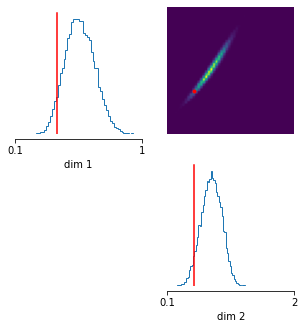

In [14]:
true_params = (0.4, 0.5)
x_0 = simulate_simple(true_params)

posterior = inference.build_posterior().set_default_x(x_0)

samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

In [65]:

percentage_list = []
for _ in range(100):
    total_theta_correct = 0
    total_x_correct = 0
    true_params = prior.sample()
    for _ in range(100):  
        x_0 = simulate_simple(true_params)      
        posterior = inference.build_posterior().set_default_x(x_0) 
        samples = posterior.sample((1000,), x=x_0)
        la, ua = np.percentile(samples.numpy(), [5, 95], axis=0)[:, 0]
        lb, ub = np.percentile(samples.numpy(), [5, 95], axis=0)[:, 1]
        if la < true_params[0] < ua:
            total_theta_correct += 1
        if lb < true_params[1] < ub:    
            total_x_correct += 1
    percentage_list.append((total_theta_correct/100, total_x_correct/100))


Drawing 1000 posterior samples: 1070it [00:00, 2300.37it/s]             
Drawing 1000 posterior samples: 1081it [00:00, 7205.28it/s]                         
Drawing 1000 posterior samples: 1087it [00:00, 3243.34it/s]                         
Drawing 1000 posterior samples: 1059it [00:00, 6313.68it/s]                         
Drawing 1000 posterior samples: 1067it [00:00, 5719.43it/s]                         
Drawing 1000 posterior samples: 1079it [00:00, 7861.80it/s]                         
Drawing 1000 posterior samples: 1087it [00:00, 3375.95it/s]                         
Drawing 1000 posterior samples: 1073it [00:00, 13314.50it/s]            
Drawing 1000 posterior samples: 1077it [00:00, 13705.59it/s]            
Drawing 1000 posterior samples: 1055it [00:00, 12718.23it/s]            
Drawing 1000 posterior samples: 1059it [00:00, 14976.07it/s]            
Drawing 1000 posterior samples: 1089it [00:00, 16298.06it/s]            
Drawing 1000 posterior samples: 1053it [00:00, 15803

In [64]:
np.array(percentage_list).mean(axis=0)

/var/folders/17/2brgtwwj25d0g2886hjmjkyc0000gn/T/ipykernel_20118/4193104716.py:1: RuntimeWarning: Mean of empty slice.
  np.array(percentage_list).mean(axis=0)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [43]:
np.percentile(samples.numpy(), [5, 95], axis=0)


array([[0.33957488, 0.84722128],
       [0.45197154, 1.10686787]])

In [47]:
np.median(samples.numpy(), axis=0)

array([0.39232865, 0.9738209 ], dtype=float32)

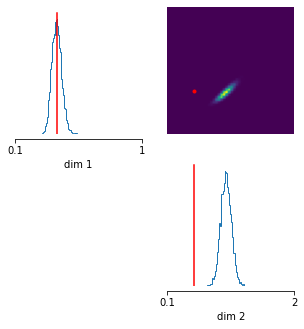

In [48]:
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1], [0.1, 2]],
    ticks=[[0.1, 1], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

In [50]:
np.percentile(samples.numpy(), [5, 95], axis=0)[:, 0]

array([0.33957488, 0.84722128])